In [1]:
import torch

from torchfem import Planar
from torchfem.materials import IsotropicPlaneStress
from torchfem.io import import_mesh
from torchfem.examples import get_example_file

## A simple cantilever beam in 2D 

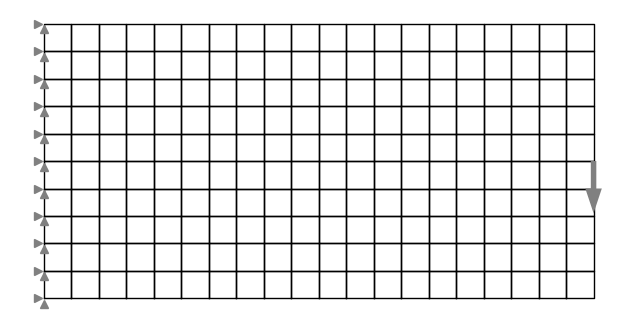

In [2]:
# Dimensions
Nx = 20
Ny = 10
Lx = 2.0
Ly = 1.0

# Material model (plane stress)
material = IsotropicPlaneStress(E=1000.0, nu=0.3)

# Create nodes
n1 = torch.linspace(0.0, Lx, Nx + 1)
n2 = torch.linspace(0.0, Ly, Ny + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(Ny):
    for i in range(Nx):
        # Quad elements
        n0 = i + j * (Nx + 1)
        elements.append([n0, n0 + 1, n0 + Nx + 2, n0 + Nx + 1])
elements = torch.tensor(elements)

# Load at tip
forces = torch.zeros_like(nodes)
forces[(int((Ny + 1) / 2) + 1) * (Nx + 1) - 1, 1] = -1.0

# Constrained displacement at left end
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
for i in range(Ny + 1):
    constraints[i * (Nx + 1), :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)
cantilever.plot()

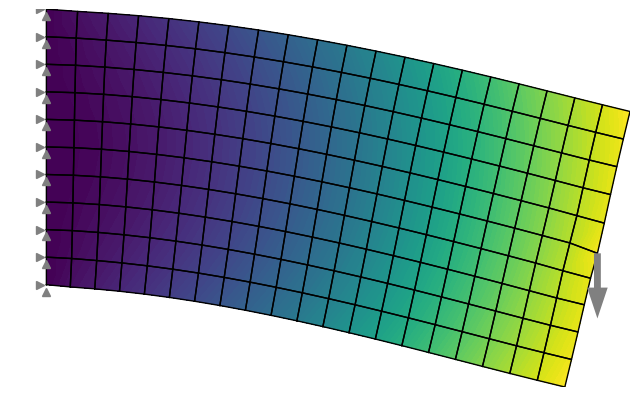

In [3]:
# Solve
u, f = cantilever.solve()
# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1))

## A simple fillet in 2D 

In [4]:
# Material model (plane stress)
material = IsotropicPlaneStress(E=1000.0, nu=0.3)

# Import mesh
specimen = import_mesh(get_example_file("fillet.vtu"), C=material.C())

# Symmetry nodes
left = specimen.nodes[:, 0] < 0.1
specimen.constraints[left, 0] = True
bottom = specimen.nodes[:, 1] < 0.1
specimen.constraints[bottom, 1] = True

# Load at right end
right = specimen.nodes[:, 0] >= specimen.nodes[:, 0].max() - 0.1
specimen.constraints[right, 0] = True
specimen.displacements[right, 0] = 6.0

In [5]:
u, f = specimen.solve()

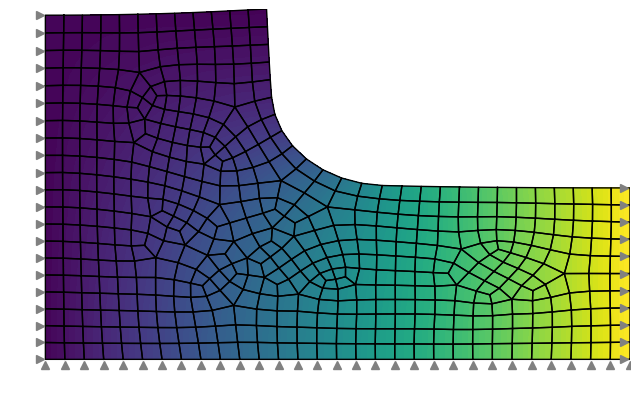

In [6]:
specimen.plot(u, node_property=u[:, 0], figsize=(8, 8))

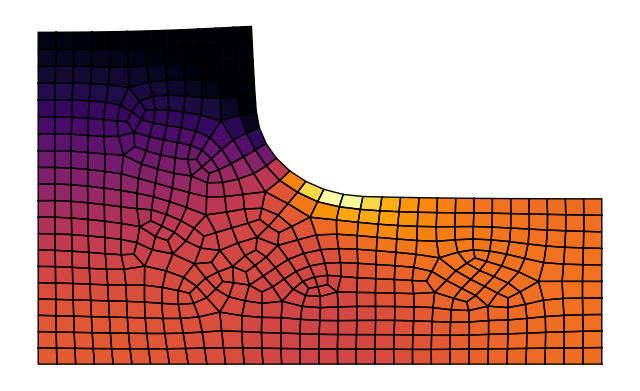

In [7]:
# Stress
mises = specimen.compute_stress(u, mises=True)
specimen.plot(u, bcs=False, element_property=mises, figsize=(8, 8), cmap="inferno")